<a href="https://colab.research.google.com/github/akshayrana30/mila-courses/blob/master/regression_example_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Linear Regression

These examples come from the "Linear Regression: In Depth" section in the PDS handbook.

We'll start with a simple regression, which has only one input variable. First
though, let's include the usual imports.

In [0]:
import seaborn as sns
import numpy as np
rng = np.random.RandomState(1) # set a seed

We'll generate data from a true linear model, $y_i = 2 x_i - 5 +
\epsilon_i$, where $x_i \sim \text{Unif}\left[0, 10\right]$ and $\epsilon_i \sim
\mathcal{N}\left(0, 1\right)$.

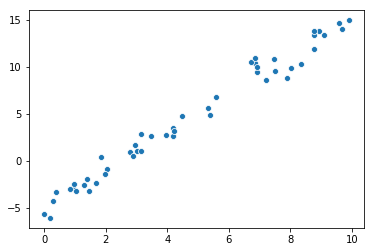

In [8]:
n = 50
x = 10 * rng.rand(n)
eps = rng.randn(n)
f = 2 * x - 5
y = f + eps
sns.scatterplot(x, y)

Let's plot the underlying linear $f\left(x\right)$, along with the errors
$\epsilon_i$.

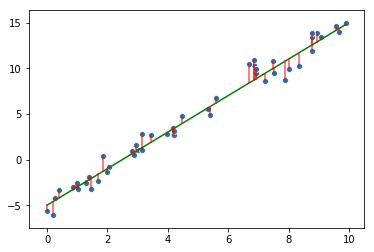

In [9]:
import matplotlib.pyplot as plt

sns.lineplot(x, f, color="green")
for i in range(n):
    plt.plot([x[i], x[i]], [f[i], y[i]], linewidth=2, color="red", alpha=0.5)
sns.scatterplot(x, y)


We can use the `LinearRegression` module in `sklearn` to fit a regression to
this data. The estimate is shown as the orange overlay.

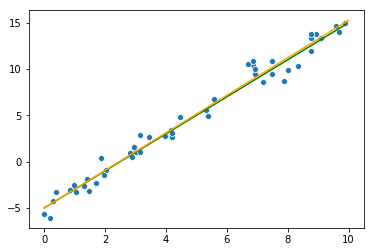

In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x[:, np.newaxis], y)
x_eval = np.linspace(0, 10, 100)
f_hat = model.predict(x_eval[:, np.newaxis])
sns.scatterplot(x, y)
sns.lineplot(x, f, color="green")
sns.lineplot(x_eval, f_hat, color="orange")


We can inspect the model's fit by looking at the coefficient and intercept
terms. It seems reasonably close to the data generating mechanism. A worthwhile
exercise is to try rerunning this code with larger and smaller $n$ and larger and smaller noise variance, to see at
how the accuracy of the estimates vary.

In [11]:
print(f"Intercept: {model.intercept_} \n Slope: {model.coef_}")

Intercept: -4.998577085553204 
 Slope: [2.02720881]


It's not too hard to run similar code for multidimensional $x$. Here's an
example with 3 input dimensions.

In [12]:
import numpy as np
# generate data
x = 10 * rng.rand(n, 3)
beta = [1.5, -2, 1]
f = 0.5 + np.dot(x, beta)
y = f + eps

# fit regression
model = LinearRegression()
model.fit(x, y)
model.coef_


array([ 1.43255837, -1.9252595 ,  0.99489009])

Let's visualize the data and the fit as well.

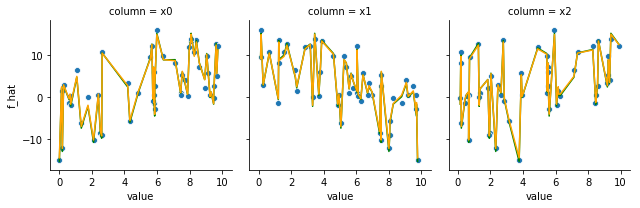

In [13]:
concat_data = np.hstack([
  y[:, np.newaxis],
  f[:, np.newaxis],
  model.predict(x)[:, np.newaxis],
  x
])

import pandas as pd

df = pd.DataFrame(concat_data).reset_index()
df.columns = ["index", "y", "f", "f_hat", "x0", "x1", "x2"]
mdf = pd.melt(df, id_vars=df.columns[:4], var_name="column")

g = sns.FacetGrid(mdf, col="column")
g.map(sns.scatterplot, "value", "y")
g.map(sns.lineplot, "value", "f", color="green") ## <-- Q:, why aren't these just lines?
g.map(sns.lineplot, "value", "f_hat", color="orange")


### Basis Functions

Let's see how we can use basis functions to fit nonlinear functions using
linear regression. Let's generate some sinusoidal data, on which to test the main
ideas.

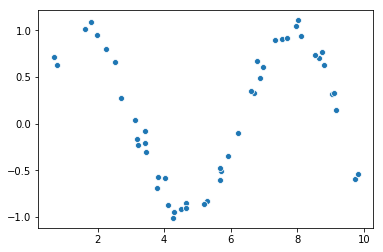

In [14]:
x = 10 * rng.rand(n)
eps = 0.1 * rng.randn(n)
f = np.sin(x)
y = f + eps

sns.scatterplot(x, y)

We'll use a polynomial basis. This can be implemented with the
`PolynomialFeatures` class in `sklearn`. We'll first try a cubic polynomial.

In [15]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(3, include_bias=False)
hx = poly.fit_transform(x[:, np.newaxis])
hx[:5] ## Q: What do the columns here correspond to?
                                       

array([[  7.55082188,  57.01491113, 430.50943874],
       [  6.98057248,  48.72839221, 340.15207388],
       [  8.6447943 ,  74.7324685 , 646.04681774],
       [  3.22680997,  10.41230257,  33.59852173],
       [  6.70788791,  44.99576018, 301.82651565]])

These are x^2 and x^3 in the other columns

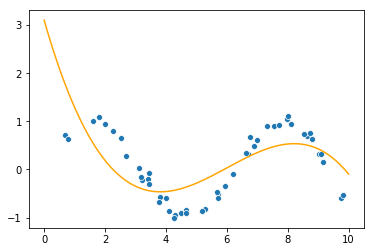

In [16]:
model = LinearRegression()
model.fit(hx, y)
h_eval = poly.fit_transform(x_eval[:, np.newaxis])
f_hat = model.predict(h_eval)

sns.scatterplot(x, y)
sns.lineplot(x_eval, f_hat, color="orange")

Not so great... but we shouldn't have expected a 3rd degree polynomial to fit something with three local extreme. Instead, let's fit a 7th degree polynomial.

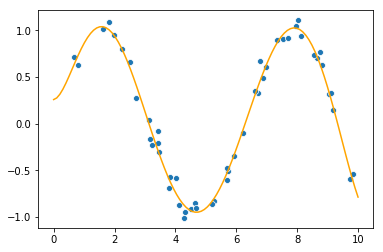

In [19]:
poly = PolynomialFeatures(7, include_bias=False)
hx = poly.fit_transform(x[:, np.newaxis])
model.fit(hx, y)
h_eval = poly.fit_transform(x_eval[:, np.newaxis])
f_hat = model.predict(h_eval)

sns.scatterplot(x, y)
sns.lineplot(x_eval, f_hat, color="orange")

As explained in the last lecture, a downside of this approach is that global polynomial fits can be very sensitive to small changes. You can already tell this by seeing how large the values in `hx` got in some of the columns. A change in one region can have an affect on the fit somewhere very far away. Instead, let's consider a more local fit. Here, we'll consider a piecewise constant fit. This isn't built into the sklearn preprocessing module, it's not a bad exercise to try implementing it ourselves. It turns out to be even simpler than the `GaussianFeatures` example in the PDS reading.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class PiecewiseConstant(BaseEstimator, TransformerMixin):
    def __init__(self, knots):
        self.knots = knots
        
    def _indicators(self, x):
        h = np.zeros([x.shape[0], len(self.knots)])
        for k_ix, k in enumerate(self.knots):
            h[:, k_ix] = x > k
        
        return h
    
    def fit(self, x, y=None):
        return self._indicators(x)

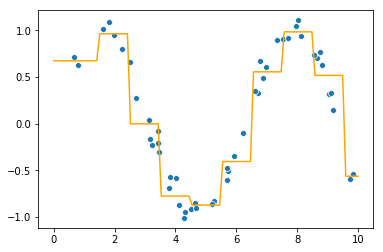

In [26]:
import numpy as np
indics = PiecewiseConstant(np.linspace(0.5, 9.5, 10))
hx = indics.fit(x)
model.fit(hx, y)

h_eval = indics.fit(x_eval)
f_hat = model.predict(h_eval)

sns.scatterplot(x, y)
sns.lineplot(x_eval, f_hat, color="orange")